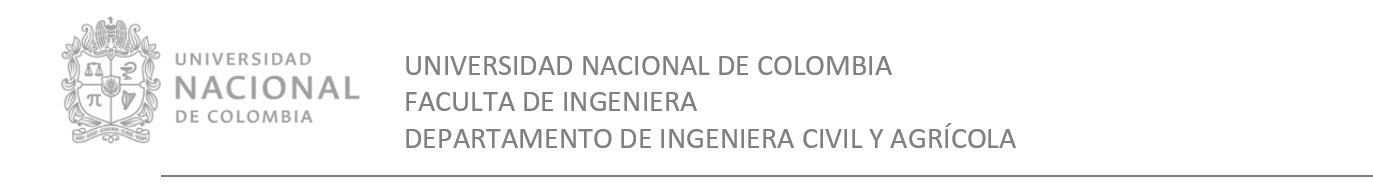

# **ANÁLISIS DE NIVELES DE SEVERIDAD   - PRACTICA 2**
----------
*CATEDRA INTERNACIONAL DE INGENIERÍA.*

*CIUDADES INTELIGENTES Y ANALÍTICA DE DATOS*

*Facultad de Ingeniería*

*Departamento de Ingeniero Civil y Agrícola*

---------------------
La siniestralidad vial es una problemática de salud pública que genera más de un millón de muertes al año a nivel mundial, en el caso de la ciudad de Bogotá, Colombia, significó 536 fatalidades para el año 2022, razón por la cual es importante el estudio sistemático para entender la siniestralidad vial, así como de la severidad de estos eventos. Con el desarrollo de algoritmos programables de aprendizaje de máquina, se ha comenzado a emplear diferentes algoritmos para estudiar la ocurrencia de siniestros y su severidad desde un enfoque estadístico y de la ciencia de datos..

> *Teniendo en cuenta lo anterior, la presente investigación tiene como objetivo la aplicación y comparación de modelos de clasificación supervisados como lo son, regresión logística (LOGREG), k vecinos cercanos (KNN), bosques aleatorios (RF), máquinas de soporte vectorial (SVM) y red neuronal multicapa (MLP) en la predicción de los niveles de severidad en los siniestros viales de la ciudad de Bogotá*


Todos los datos han sido anonimizados, así como, se ha modificado la base de datos con fines académicos.

## I. PROBLEMA DE INVESTIGACIÓN
-------------

La siniestralidad vial se clasifica de acuerdo con la gravedad o el tipo de colisión, comúnmente se modela la frecuencia y la gravedad por separado; sin embargo, algunos investigadores han trabajado modelos de frecuencia para los diferentes tipos de gravedad de los siniestros viales; En los últimos años la comunidad científica ha adelantado estudios para el entendimiento de la severidad de los siniestros viales aplicando modelos no paramétricos y algoritmos basados en el aprendizaje de máquina.
De esta manera, el código presenta la aplicación de técnicas de ML orientadas a la predicción de la severidad de los siniestros viales en la ciudad de Bogotá, esta metodología permite el diseño de herramientas y medidas orientadas a la mitigación de altos niveles de severidad.



## II.	IMPORTACIÓN DE LIBRERÍAS
------------------------------
Dentro de los elementos básicos en el análisis en Python es la correcta importación y cargue de las librerías.

In [148]:

import sklearn
# Otras librerías de utilidad
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import warnings
from scipy import stats
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')

# Las figuras en formato retina se ven más limpias
%config InlineBackend.figure_format = 'retina'

# Configuraciones de Matplotlib
%matplotlib inline
plt.rcParams['figure.dpi'] = 250
mpl.rcParams['figure.figsize'] = (9, 7)

# Estilo por defecto para notebooks.
sns.set_theme('notebook')

### 1. FUNCIONES DE UTILIDAD
----------

El siguiente apartado muestra algunas de las funciones importantes para entender el próximo desarrollo de las funciones.

In [149]:
# Gracicar la curva de aprendizaje de determinada métrica de agrupamiento.

def plot_metric(K, scores, metric_name):
  plt.figure(dpi=110, figsize=(9, 5))
  plt.plot(K, scores, 'bx-')
  plt.xticks(K); plt.xlabel('$k$', fontdict=dict(family = 'serif', size = 14));  plt.ylabel(metric_name, fontdict=dict(family = 'serif', size = 14));
  plt.title(f'K vs {metric_name}', fontdict=dict(family = 'serif', size = 18))
  plt.show()

In [150]:
from mlxtend.plotting import plot_decision_regions

# Función para visualizar la superficie de decisión de un clasificador.
def plot_decision_region(X, y, clf, classes, title = ""):
  fig, ax = plt.subplots(dpi = 120)
  plot_decision_regions(X, y, clf = clf, ax = ax)
  handles, _ = ax.get_legend_handles_labels()
  ax.legend(handles, classes)
  ax.set_title(title)
  fig.show()

In [151]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))

  return df

In [152]:
# Función para evaluar en conjunto diferentes medidas de tendencia central y estadísticos de descriptivos.
def describe2(df, stats):
  d = (df.describe().round(2)).iloc[:,0:]
  return d.append(df.reindex(d.columns, axis = 1).agg(stats)).round(2)

In [153]:
# Gráficar la predicción de los datos de temperatura.

def plot_prediction(params, ys, test_date_index):

  train_data = serie_dia.loc[:test_date_index[0]]
  _y_test, _y_forward, _y_last = ys
  # Graficamos los valores predichos.
  fig = go.Figure(layout = dict(
       title = f'<b>Siniestros viales en Bogota (01/10/22 - 14/10/23)</b> <br> {params}',
       dragmode= 'pan', width = 1200, height = 600))

  fig.add_trace(go.Scatter(x = train_data.index,  # Datos originales hasta la primer semana predicha. (fechas)
                          y = train_data.values, # Datos originales hasta la primer semana predicha. (temperaturas)
                          mode = 'lines',
                          name = 'Valores de entrenamiento y pruebas'))

  #Gráfica de los valores de prueba reales.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_test,
                          mode='lines+markers',
                          name='Valores reales (y)'))


  #Gráfica de los valores predichos a partir de las ventanas de X_test.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_forward,
                          mode = 'lines+markers',
                          name = 'Valores predichos a partir de datos reales'))

  #Gráfica de los valores predichos a partir de ventanas creadas proceduralmente.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_last,
                          mode='lines+markers',
                          name='Valores predichos a partir de datos predichos'))

  fig.show(config = dict({'scrollZoom': True}))

In [154]:
# Gráfica de la varianza explicada acumulada.

def cumulative_explained_variance_plot(expl_variance):

  cum_var_exp = np.cumsum(expl_variance)

  plt.figure(dpi = 100, figsize = (8, 6))
  plt.title('Curva acumulativa de la varianza explicada VS n° de componentes principales',
            fontdict= dict(family ='serif', size = 16))
  plt.xlabel('Número de componentes principales',
             fontdict= dict(family ='serif', size = 14))
  plt.ylabel('Varianza explicada acumulativa',
             fontdict= dict(family ='serif', size = 14))

  nc = np.arange(1, expl_variance.shape[0] + 1)

  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'c*', ms = 5)
  plt.show()

## III PREPARACION Y PREPROCESAMIENTO
--------------
El trabajo se encuentra dividido en dos apartados, el primero de estos se enfoca en el análisis de la siniestralidad y los actores viales, así bien, a partir de la información del SIMIT (Sistema de Información de Accidentes de Tránsito) de los actores viales se busca identificar los niveles de severidad de los diferentes siniestros registrados.

### 1.	CARGA DE DATOS
----------
En este apartado se carga la base de datos de los actores viales para los siniestros de 2021, para el respectivo análisis.

In [155]:
#Cargue de la base de datos.
ACTORV_df = pd.read_csv('/content/Practica_2_Severidad.csv',engine='python')
ACTORV_df['FECHA'] = pd.to_datetime(ACTORV_df['FECHA'])
ACTORV_df['EDAD'] = ACTORV_df['EDAD'].astype('Int64')
ACTORV_df['MOD_VEHICULO'] = ACTORV_df['MOD_VEHICULO'].astype('Int64')
ACTORV_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FORMULARIO         10000 non-null  object        
 1   CODIGO_ACCIDENTE   10000 non-null  int64         
 2   FECHA              10000 non-null  datetime64[ns]
 3   CODIGO_VICTIMA     10000 non-null  int64         
 4   CODIGO_VEHICULO    9069 non-null   float64       
 5   TIPO_ACTOR         9999 non-null   object        
 6   ESTADO             9763 non-null   object        
 7   GENERO             9659 non-null   object        
 8   EDAD               9600 non-null   Int64         
 9   GRAVEDAD           10000 non-null  int64         
 10  CLASE_SINIESTRO    10000 non-null  int64         
 11  DIRECCION          10000 non-null  object        
 12  LONGITUD           10000 non-null  float64       
 13  LATITUD            10000 non-null  float64       
 14  CODIGO_

### 2.	PREPARACIÓN DE BASES DE DATOS
------------------------
En la siguiente sección se realiza la limpieza de las diferentes bases de datos, y se aplican funciones para la selección condicional a partir del conocimiento de la problemática.

In [156]:
#Identificación de los bici usuarios
ACTORV_df["MOD_VEHICULO"] = np.where(ACTORV_df["TIPO_ACTOR"] == "CICLISTA", 5000, ACTORV_df["MOD_VEHICULO"])
ACTORV_df["CLASE_VEHICULO"] = np.where(ACTORV_df["TIPO_ACTOR"] == "CICLISTA", 13, ACTORV_df["CLASE_VEHICULO"])
ACTORV_df["SERVICIO_VEHICULO"] = np.where(ACTORV_df["TIPO_ACTOR"] == "CICLISTA", 5, ACTORV_df["SERVICIO_VEHICULO"])

ACTORV_df["MOD_VEHICULO"] = np.where(ACTORV_df["TIPO_ACTOR"] == "PEATON", 3000, ACTORV_df["MOD_VEHICULO"])
ACTORV_df["CLASE_VEHICULO"] = np.where(ACTORV_df["TIPO_ACTOR"] == "PEATON", 30, ACTORV_df["CLASE_VEHICULO"])
ACTORV_df["SERVICIO_VEHICULO"] = np.where(ACTORV_df["TIPO_ACTOR"] == "PEATON", 6, ACTORV_df["SERVICIO_VEHICULO"])


In [157]:
#Limpieza de la base de datos a partir de la información ml digitada.
ACTORV_df = ACTORV_df[      (ACTORV_df['GENERO'] != 'SIN INFORMACION') &
                            (ACTORV_df['TIPO_ACTOR'].notnull()) &
                            (ACTORV_df['GENERO'].notnull()) &
                            (ACTORV_df['ESTADO'].notnull()) &
                            (ACTORV_df['MOD_VEHICULO'].notnull()) &
                            (ACTORV_df['MOD_VEHICULO'] >= 1950) &
                            (ACTORV_df['CLASE_VEHICULO'].notnull()) &
                            (ACTORV_df['CLASE_VEHICULO'] != 0) &
                            (ACTORV_df['SERVICIO_VEHICULO'].notnull()) &
                            (ACTORV_df['CODIGO_CAUSA'].notnull()) &
                            (ACTORV_df['CODIGO_CAUSA'] != 0) &
                            (ACTORV_df['EDAD'] >= 5) &
                            (ACTORV_df['EDAD'] <= 85)
                                                                ]

In [158]:
# Limpieza variables con menor cantidad de registros
counts_clase = ACTORV_df['CLASE_VEHICULO'].value_counts()
ACTORV_df = ACTORV_df[~ACTORV_df['CLASE_VEHICULO'].isin(counts_clase[counts_clase < 100].index)]
counts_servicio = ACTORV_df['SERVICIO_VEHICULO'].value_counts()
ACTORV_df = ACTORV_df[~ACTORV_df['SERVICIO_VEHICULO'].isin(counts_servicio[counts_servicio < 200].index)]
counts_siniestro = ACTORV_df['CLASE_SINIESTRO'].value_counts()
ACTORV_df = ACTORV_df[~ACTORV_df['CLASE_SINIESTRO'].isin(counts_siniestro[counts_siniestro < 750].index)]

In [159]:
counts_siniestro

,count
CLASE_SINIESTRO,
1,6766
2,1443
4,336
3,211
6,51


In [160]:
#Unión de causas en categorías de variables con menos cantidad de registros.
counts_causa = ACTORV_df['CODIGO_CAUSA'].value_counts()
ACTORV_df["CODIGO_CAUSA"] = np.where(ACTORV_df['CODIGO_CAUSA'].isin(counts_causa[counts_causa <= 1000].index), 1000, ACTORV_df["CODIGO_CAUSA"])

In [161]:
#Discriminación de variables en grupos a partir del conocimiento.
ACTORV_df["EDAD_CAT"] =pd.cut(x=ACTORV_df['EDAD'], bins=[0,11,18,26,59,100])
ACTORV_df["MODELO_CAT"] =pd.cut(x=ACTORV_df['MOD_VEHICULO'], bins=[1900,1990,2000,2010,2015,2020,2025,3500,10000])

In [162]:
#Conversión de códigos a parámetros categoricos
ACTORV_df.loc[ACTORV_df["CLASE_SINIESTRO"] == 1, "CLASE_SINIESTRO"] = 'CHOQUE'
ACTORV_df.loc[ACTORV_df["CLASE_SINIESTRO"] == 2, "CLASE_SINIESTRO"] = 'ATROPELLO'
ACTORV_df.loc[ACTORV_df["CLASE_SINIESTRO"] == 3, "CLASE_SINIESTRO"] = 'VOLVAMIENTO'
ACTORV_df.loc[ACTORV_df["CLASE_SINIESTRO"] == 4, "CLASE_SINIESTRO"] = 'CAIDA_OCC'

In [163]:
#Conversión de códigos a parámetros categoricos
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 1, "CLASE_VEHICULO"] = 'AUTOMOVIL'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 2, "CLASE_VEHICULO"] = 'BUS'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 3, "CLASE_VEHICULO"] = 'BUSETA'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 4, "CLASE_VEHICULO"] = 'CAMION'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 5, "CLASE_VEHICULO"] = 'CAMIONETA'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 6, "CLASE_VEHICULO"] = 'CAMPERO'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 7, "CLASE_VEHICULO"] = 'MICROBUS'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 8, "CLASE_VEHICULO"] = 'TRACTOCAMION'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 9, "CLASE_VEHICULO"] = 'VOLQUETA'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 10, "CLASE_VEHICULO"] = 'MOTOCICLETA'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 13, "CLASE_VEHICULO"] = 'BICICLETA'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 17, "CLASE_VEHICULO"] = 'MOTOCICLO'
ACTORV_df.loc[ACTORV_df["CLASE_VEHICULO"] == 30, "CLASE_VEHICULO"] = 'MOD_PEATONAL'

In [164]:
#Conversión de códigos a parámetros categoricos
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 1000, "CODIGO_CAUSA"] = 'OTRAS'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 98, "CODIGO_CAUSA"] = 'TRANSIT_ENTRE_VEH'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 102, "CODIGO_CAUSA"] = 'ADELANTAR_DER'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 103, "CODIGO_CAUSA"] = 'ADELANTAR_CERR'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 104, "CODIGO_CAUSA"] = 'ADELANTAR_INVA'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 106, "CODIGO_CAUSA"] = 'ADELANTAR_INVA'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 112, "CODIGO_CAUSA"] = 'DESOBEDECER_SENAL'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 114, "CODIGO_CAUSA"] = 'EMBRIAGUEZ'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 115, "CODIGO_CAUSA"] = 'EMBRIAGUEZ'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 119, "CODIGO_CAUSA"] = 'FRENAR_BRUSC'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 121, "CODIGO_CAUSA"] = 'NO_MANTENER_DIST'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 122, "CODIGO_CAUSA"] = 'NO_SENAL_GIRO'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 123, "CODIGO_CAUSA"] = 'NO_RESP_PREL'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 127, "CODIGO_CAUSA"] = 'CONTRAVIA'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 132, "CODIGO_CAUSA"] = 'NO_RESP_PREL'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 134, "CODIGO_CAUSA"] = 'REVERSO_IMPRU'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 139, "CODIGO_CAUSA"] = 'IMPERICIA_MANEJO'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 141, "CODIGO_CAUSA"] = 'VEHICLO_MAL_EST'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 142, "CODIGO_CAUSA"] = 'SEMAFORO_ROJO'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 143, "CODIGO_CAUSA"] = 'ARRANCAR_SIN_PREC'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 145, "CODIGO_CAUSA"] = 'ARRANCAR_SIN_PREC'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 157, "CODIGO_CAUSA"] = 'NO_DETALLE'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 306, "CODIGO_CAUSA"] = 'HUECOS'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 409, "CODIGO_CAUSA"] = 'NO_OBSERVAR'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 411, "CODIGO_CAUSA"] = 'OTRAS'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 506, "CODIGO_CAUSA"] = 'OTRAS'
ACTORV_df.loc[ACTORV_df["CODIGO_CAUSA"] == 750, "CODIGO_CAUSA"] = 'MANT_MECANICO'

In [165]:
#Conversión de códigos a parámetros categoricos
ACTORV_df.loc[ACTORV_df["SERVICIO_VEHICULO"] == 1, "SERVICIO_VEHICULO"] = 'OFICIAL'
ACTORV_df.loc[ACTORV_df["SERVICIO_VEHICULO"] == 2, "SERVICIO_VEHICULO"] = 'PUBLICO'
ACTORV_df.loc[ACTORV_df["SERVICIO_VEHICULO"] == 3, "SERVICIO_VEHICULO"] = 'PARTICULAR'
ACTORV_df.loc[ACTORV_df["SERVICIO_VEHICULO"] == 5, "SERVICIO_VEHICULO"] = 'SER_BICICLETA'
ACTORV_df.loc[ACTORV_df["SERVICIO_VEHICULO"] == 6, "SERVICIO_VEHICULO"] = 'SER_PEATONAL'

In [166]:
#Parametrización de la variable respuesta en códigos para los siguientes modelos.
ACTORV_df.loc[ACTORV_df["GRAVEDAD"] == 1, "GRAVEDAD"] = 0
ACTORV_df.loc[ACTORV_df["GRAVEDAD"] == 2, "GRAVEDAD"] = 1
ACTORV_df.loc[ACTORV_df["GRAVEDAD"] == 3, "GRAVEDAD"] = 2

In [167]:
#Eliminación de valores faltantes o nulos
ACTOR_ML=ACTORV_df[['GRAVEDAD', 'TIPO_ACTOR','GENERO','CLASE_SINIESTRO','CLASE_VEHICULO','SERVICIO_VEHICULO','CODIGO_CAUSA','MODELO_CAT','EDAD']]
ACTOR_ML = ACTOR_ML.dropna(axis=0)
ACTOR_ML.head(10)

,GRAVEDAD,TIPO_ACTOR,GENERO,CLASE_SINIESTRO,CLASE_VEHICULO,SERVICIO_VEHICULO,CODIGO_CAUSA,MODELO_CAT,EDAD
1,1,CONDUCTOR,MASCULINO,CHOQUE,AUTOMOVIL,PARTICULAR,OTRAS,"(2015, 2020]",21
2,0,CONDUCTOR,MASCULINO,CHOQUE,AUTOMOVIL,PARTICULAR,OTRAS,"(2015, 2020]",22
3,1,CONDUCTOR,MASCULINO,CHOQUE,AUTOMOVIL,PARTICULAR,NO_DETALLE,"(2015, 2020]",52
4,1,MOTOCICLISTA,MASCULINO,CHOQUE,MOTOCICLETA,PARTICULAR,OTRAS,"(2015, 2020]",35
5,1,ACOMPANANTE,FEMENINO,CHOQUE,MOTOCICLETA,PARTICULAR,DESOBEDECER_SENAL,"(2010, 2015]",14
6,0,MOTOCICLISTA,FEMENINO,CHOQUE,MOTOCICLETA,PARTICULAR,OTRAS,"(2015, 2020]",35
7,1,MOTOCICLISTA,MASCULINO,CHOQUE,MOTOCICLETA,PARTICULAR,NO_DETALLE,"(2015, 2020]",22
9,0,PASAJERO,MASCULINO,CHOQUE,BUS,PUBLICO,OTRAS,"(2010, 2015]",21
10,1,CONDUCTOR,MASCULINO,CHOQUE,CAMIONETA,PARTICULAR,OTRAS,"(1900, 1990]",58
11,1,MOTOCICLISTA,MASCULINO,CHOQUE,MOTOCICLETA,PARTICULAR,OTRAS,"(2010, 2015]",35


### 3. ESTADÍSTICA DESCRIPTIVA
------------
Para el mayor entendimiento de la problemática resulta idóneo la aplicación de técnicas de estadística descriptiva, así bien, para las variables categóricas se aplicaran tablas pivot que permiten el adecuado estudio de este tipo de variables.

In [168]:
PIV_ACTOR = ACTOR_ML.pivot_table(ACTOR_ML, index=['GRAVEDAD','GENERO'],columns=['TIPO_ACTOR'],
                    aggfunc={'TIPO_ACTOR': 'count'}).fillna(0).astype(int)
PIV_ACTOR_DF=PIV_ACTOR.reset_index()
PIV_VEHICULO = ACTOR_ML.pivot_table(ACTOR_ML, index=['GRAVEDAD','GENERO'],columns=['CLASE_VEHICULO'],
                    aggfunc={'CLASE_VEHICULO': 'count'}).fillna(0).astype(int)
PIV_VEHICULO_DF=(PIV_VEHICULO .reset_index()).iloc[:,2:]

#PIV_EDAD = ACTOR_ML.pivot_table(ACTOR_ML, index=['GRAVEDAD','GENERO'],columns=['EDAD_CAT'],
#                    aggfunc={'EDAD_CAT': 'count'}).fillna(0).astype(int)
#PIV_EDAD_DF=(PIV_EDAD.reset_index()).iloc[:,2:]
df_CONCAT=pd.concat([PIV_ACTOR_DF,PIV_VEHICULO_DF], axis=1)
df_CONCAT

GRAVEDAD     GENERO  TIPO_ACTOR                                           \
                      ACOMPANANTE CICLISTA CONDUCTOR MOTOCICLISTA PASAJERO   
0        0   FEMENINO         107       18        26           40       29   
1        0  MASCULINO          77      150       424          438       32   
2        1   FEMENINO         493      186       266          216      190   
3        1  MASCULINO         215      558      2154         1671       97   

         CLASE_VEHICULO                                                   \
  PEATON      AUTOMOVIL BICICLETA  BUS CAMION CAMIONETA CAMPERO MICROBUS   
0     74             52        18    9      1        13       3        6   
1    172            153       150  140     80        78      13       18   
2    263            407       186   60      7        84      26       19   
3    313           1275       558  320    114       470      90       58   

                            
  MOD_PEATONAL MOTOCICLETA  
0           74         118  
1          172         489  
2          263         562  
3          313        1810

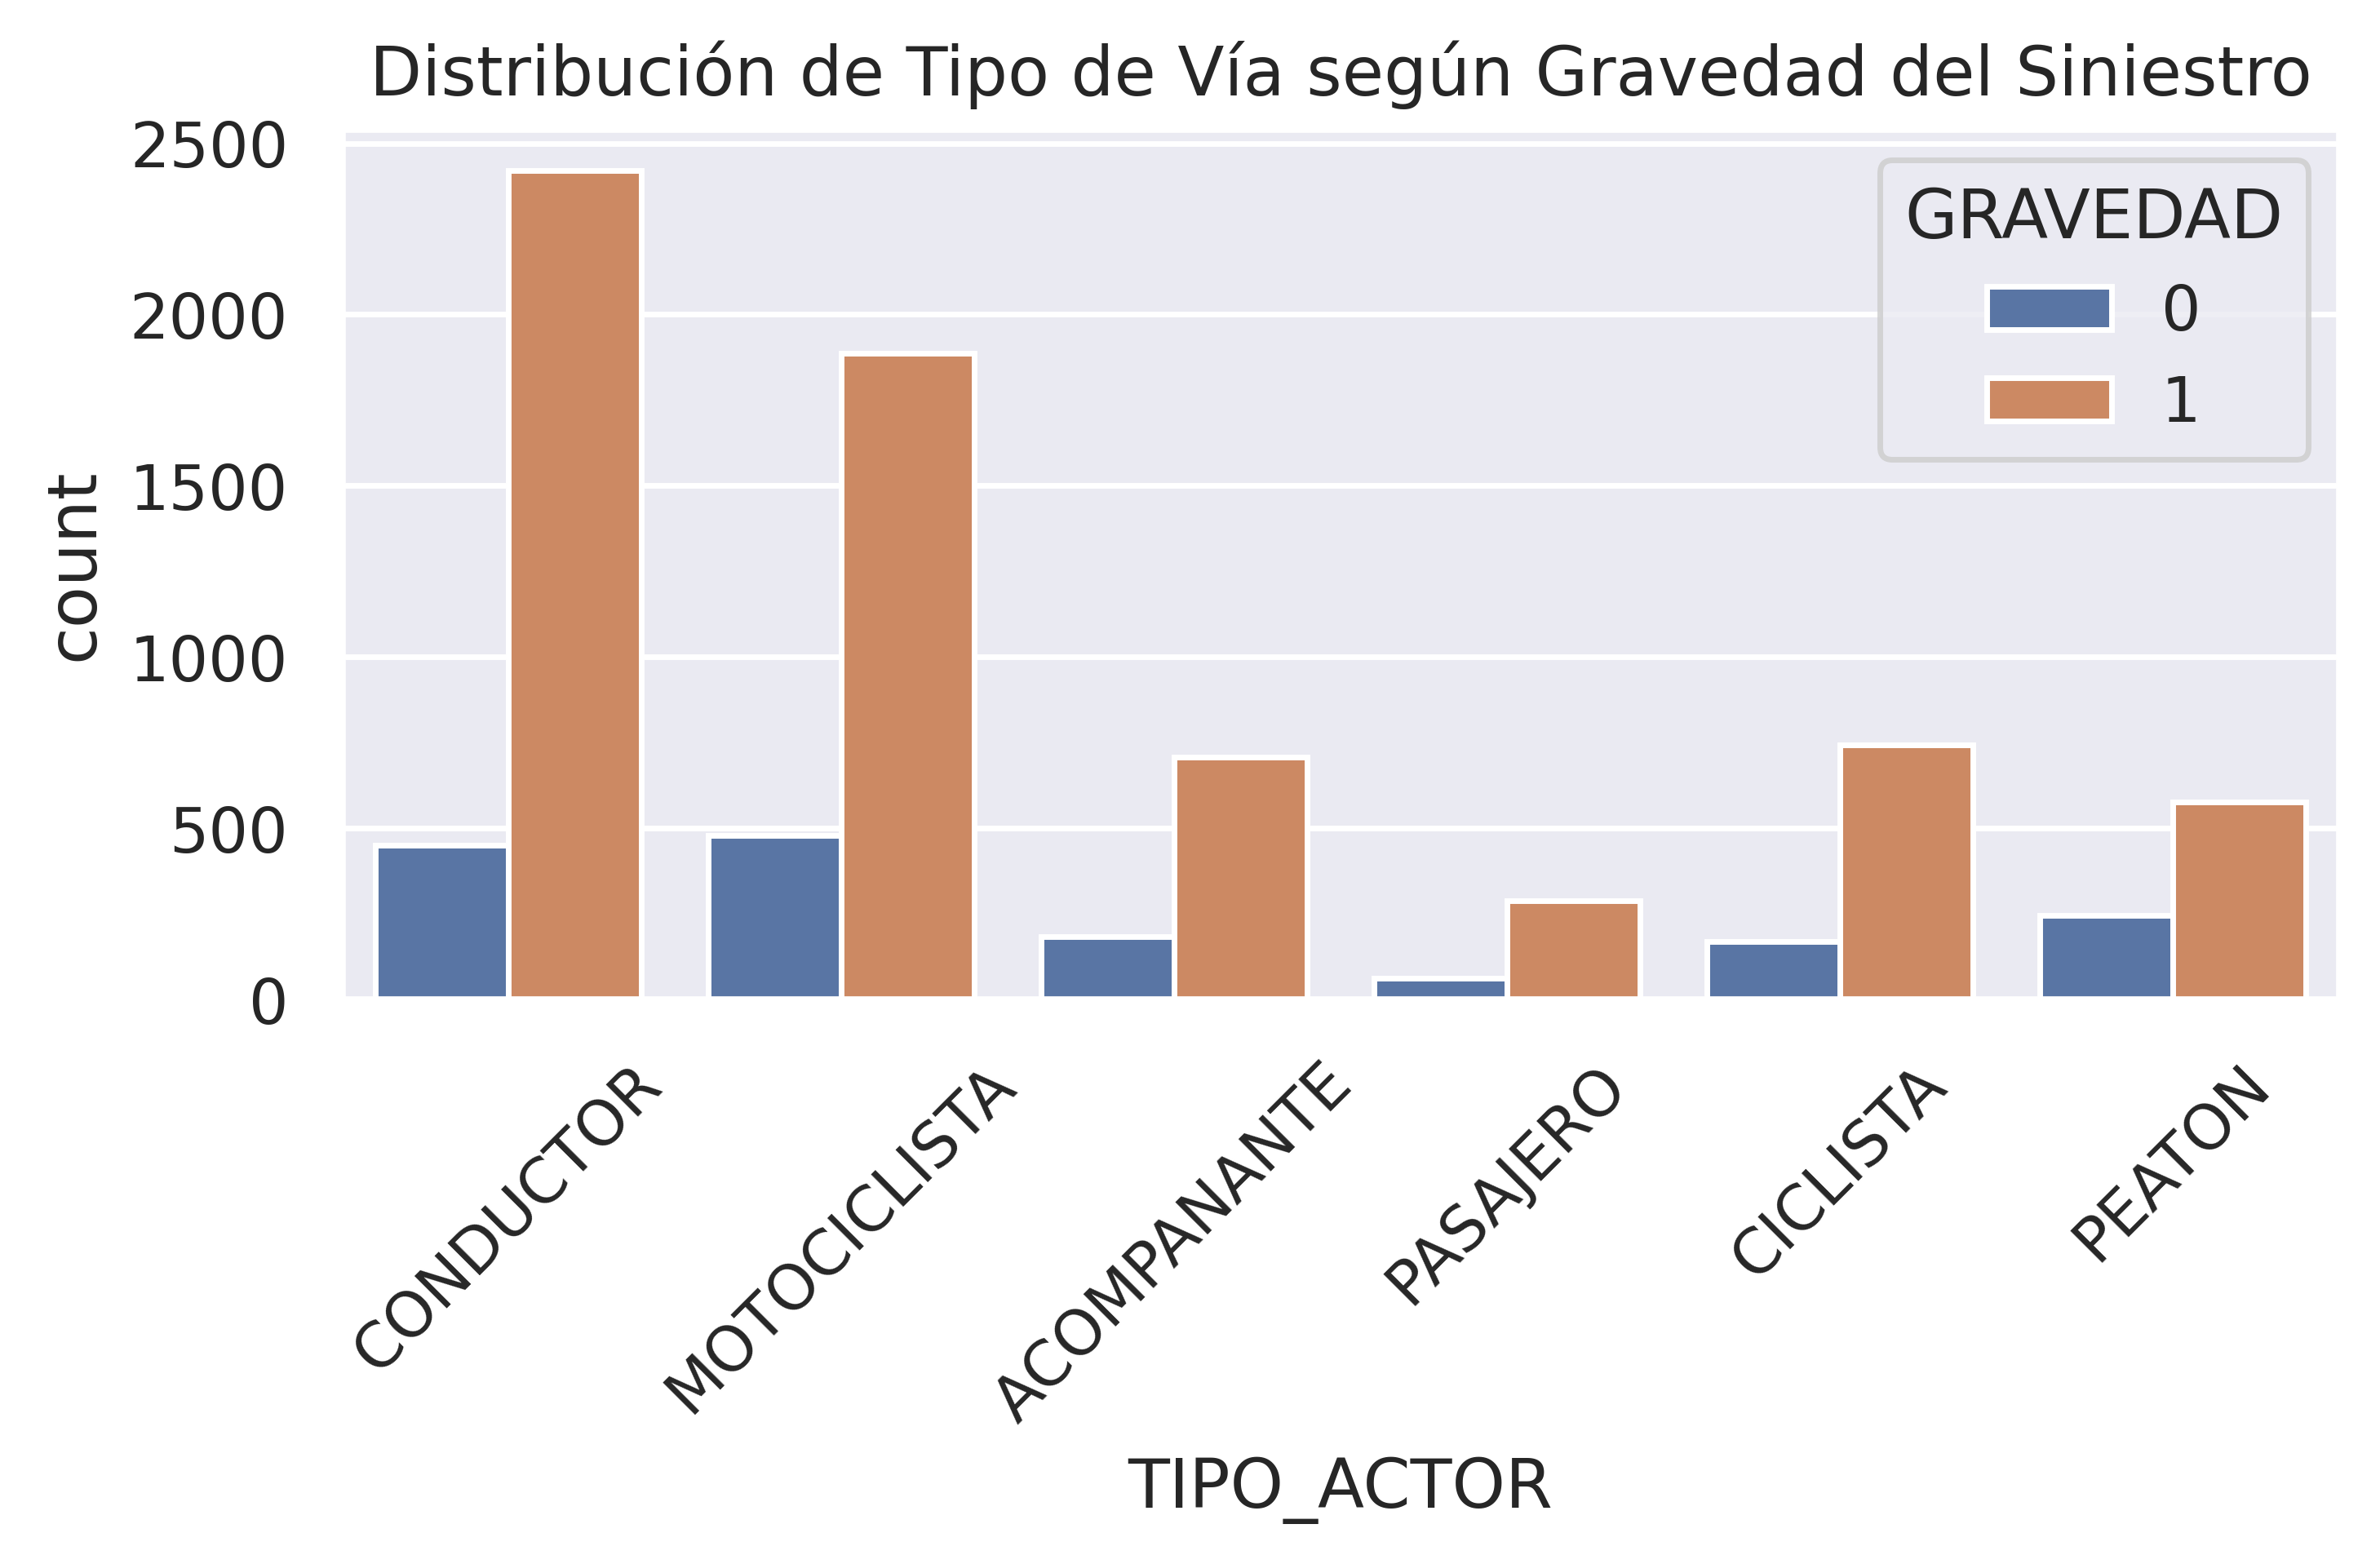

In [169]:
plt.figure(figsize=(6, 4))
sns.countplot(data=ACTOR_ML, x='TIPO_ACTOR', hue='GRAVEDAD')
plt.title('Distribución de Tipo de Vía según Gravedad del Siniestro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

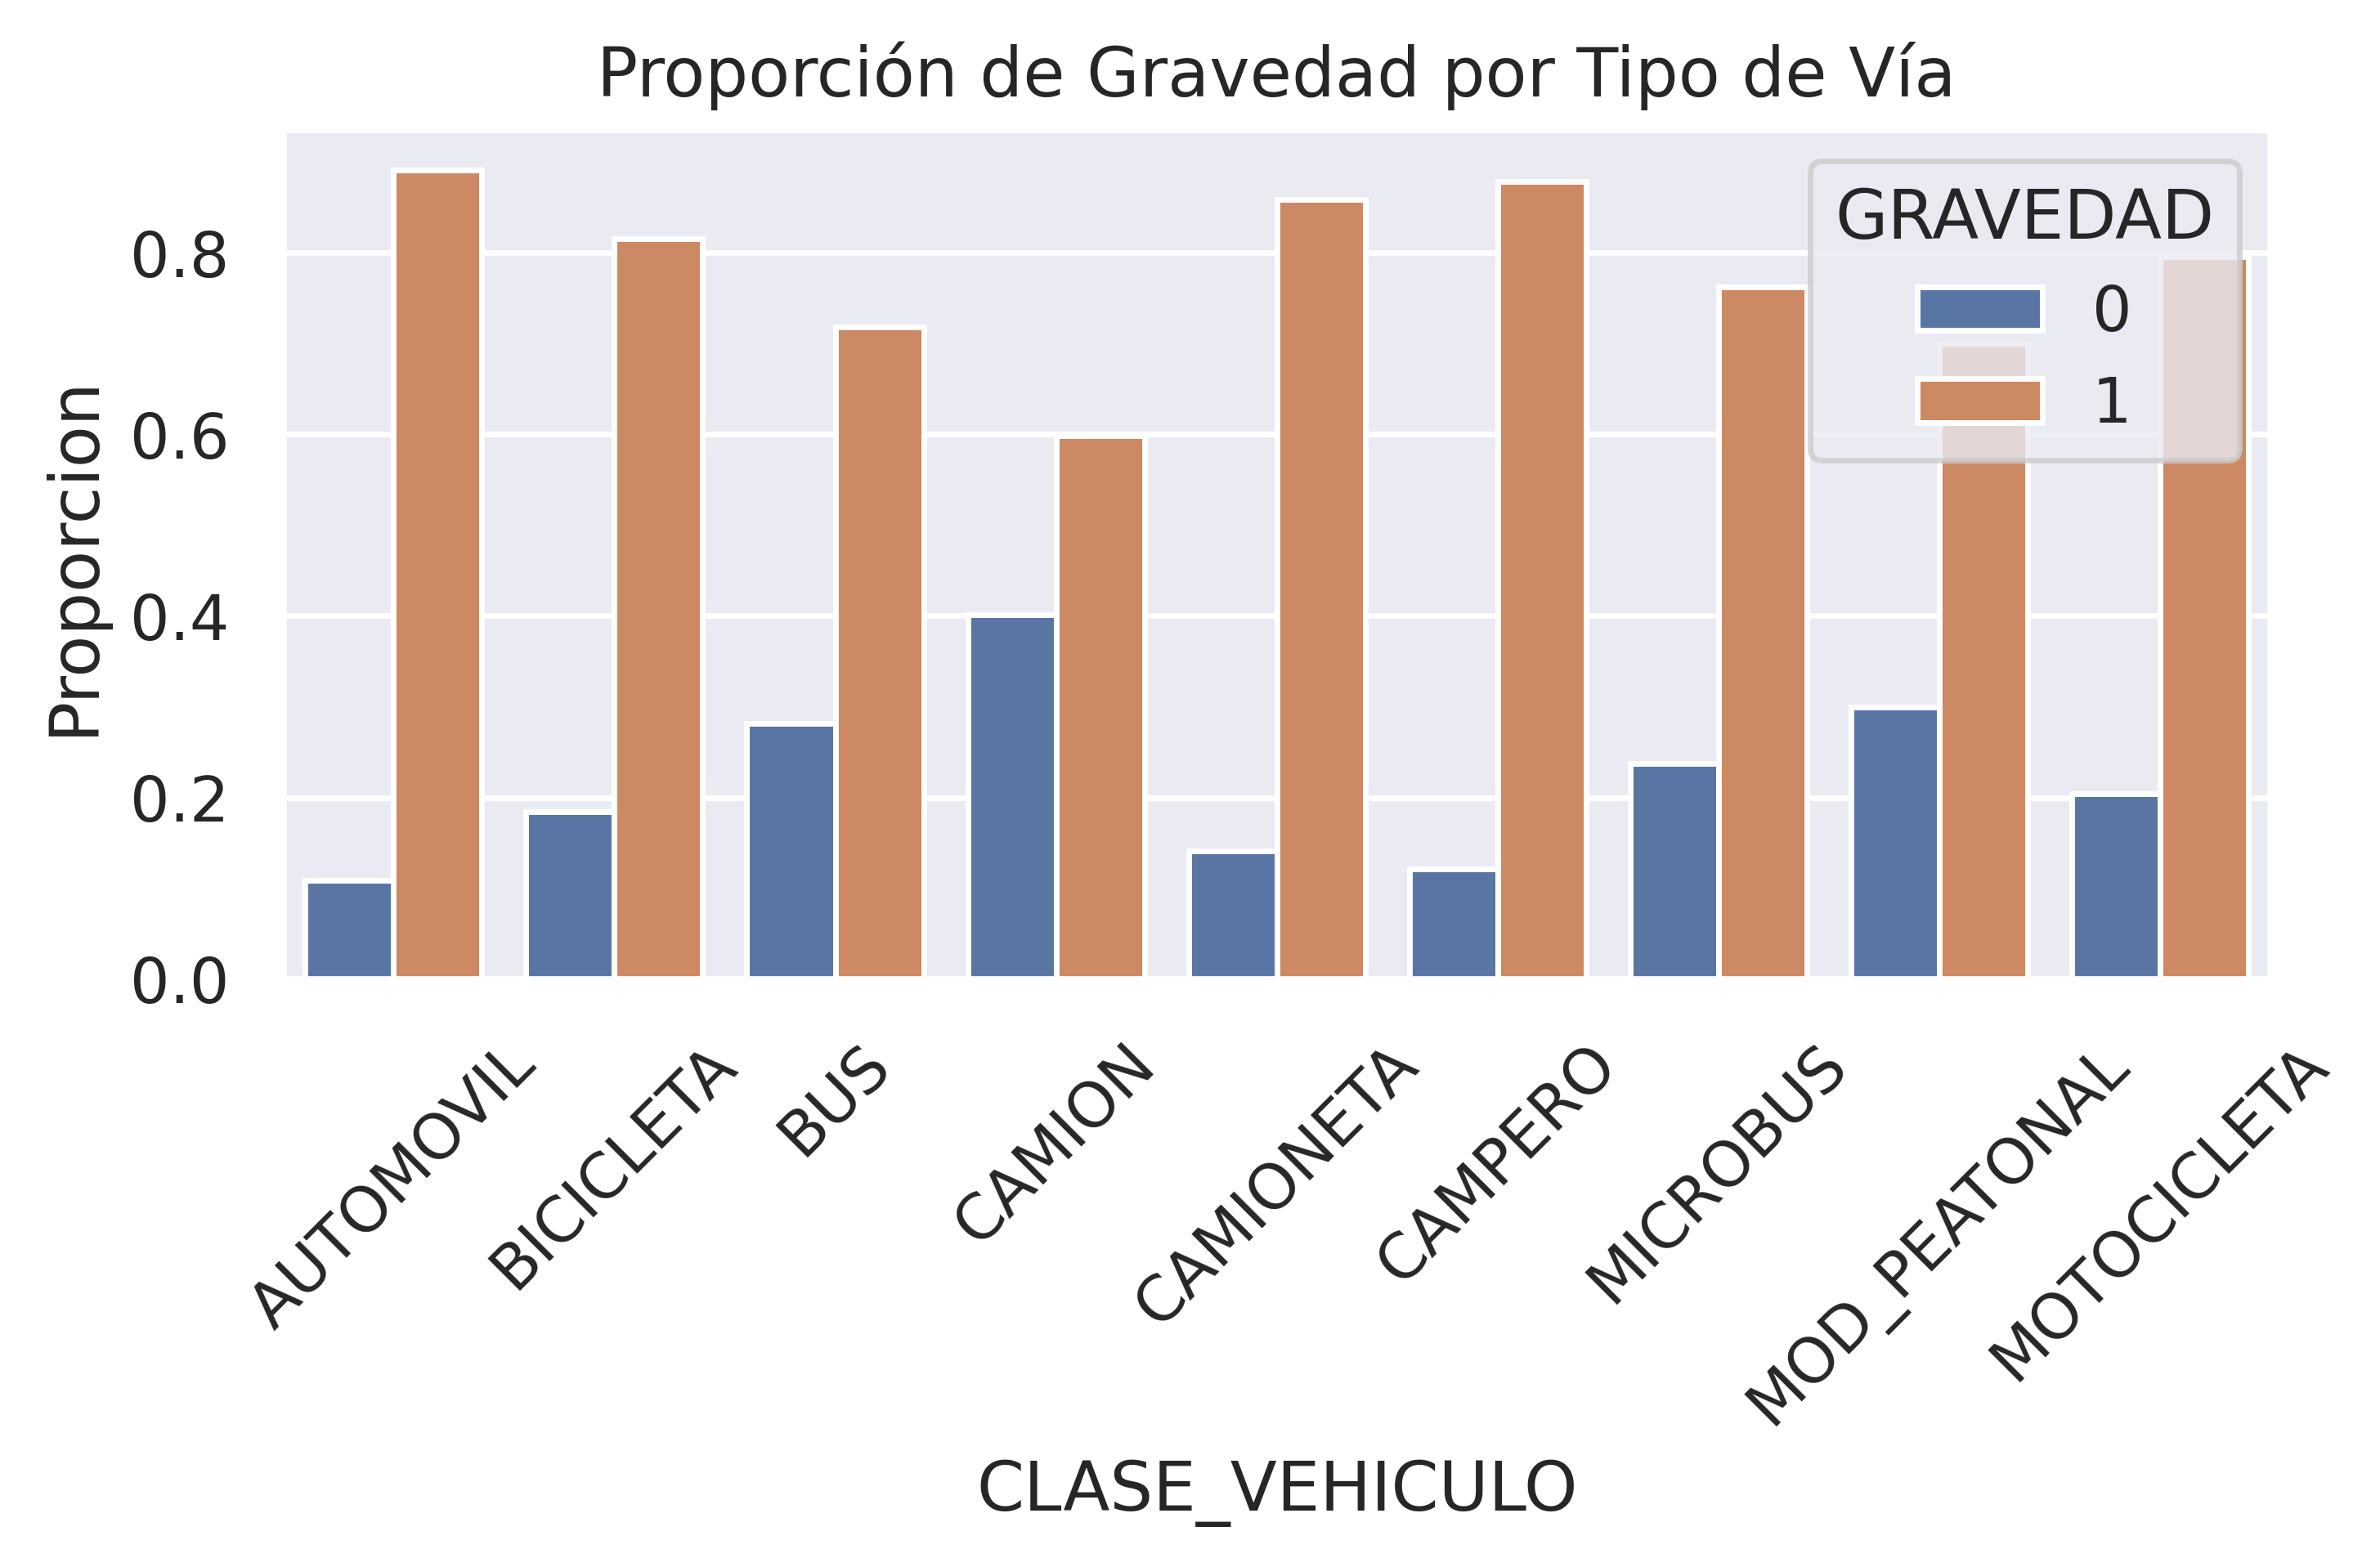

In [170]:
proporcion = (ACTOR_ML.groupby('CLASE_VEHICULO')['GRAVEDAD']
                .value_counts(normalize=True)
                .rename('Proporcion')
                .reset_index())

plt.figure(figsize=(6, 4))
sns.barplot(data=proporcion, x='CLASE_VEHICULO', y='Proporcion', hue='GRAVEDAD')
plt.title('Proporción de Gravedad por Tipo de Vía')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

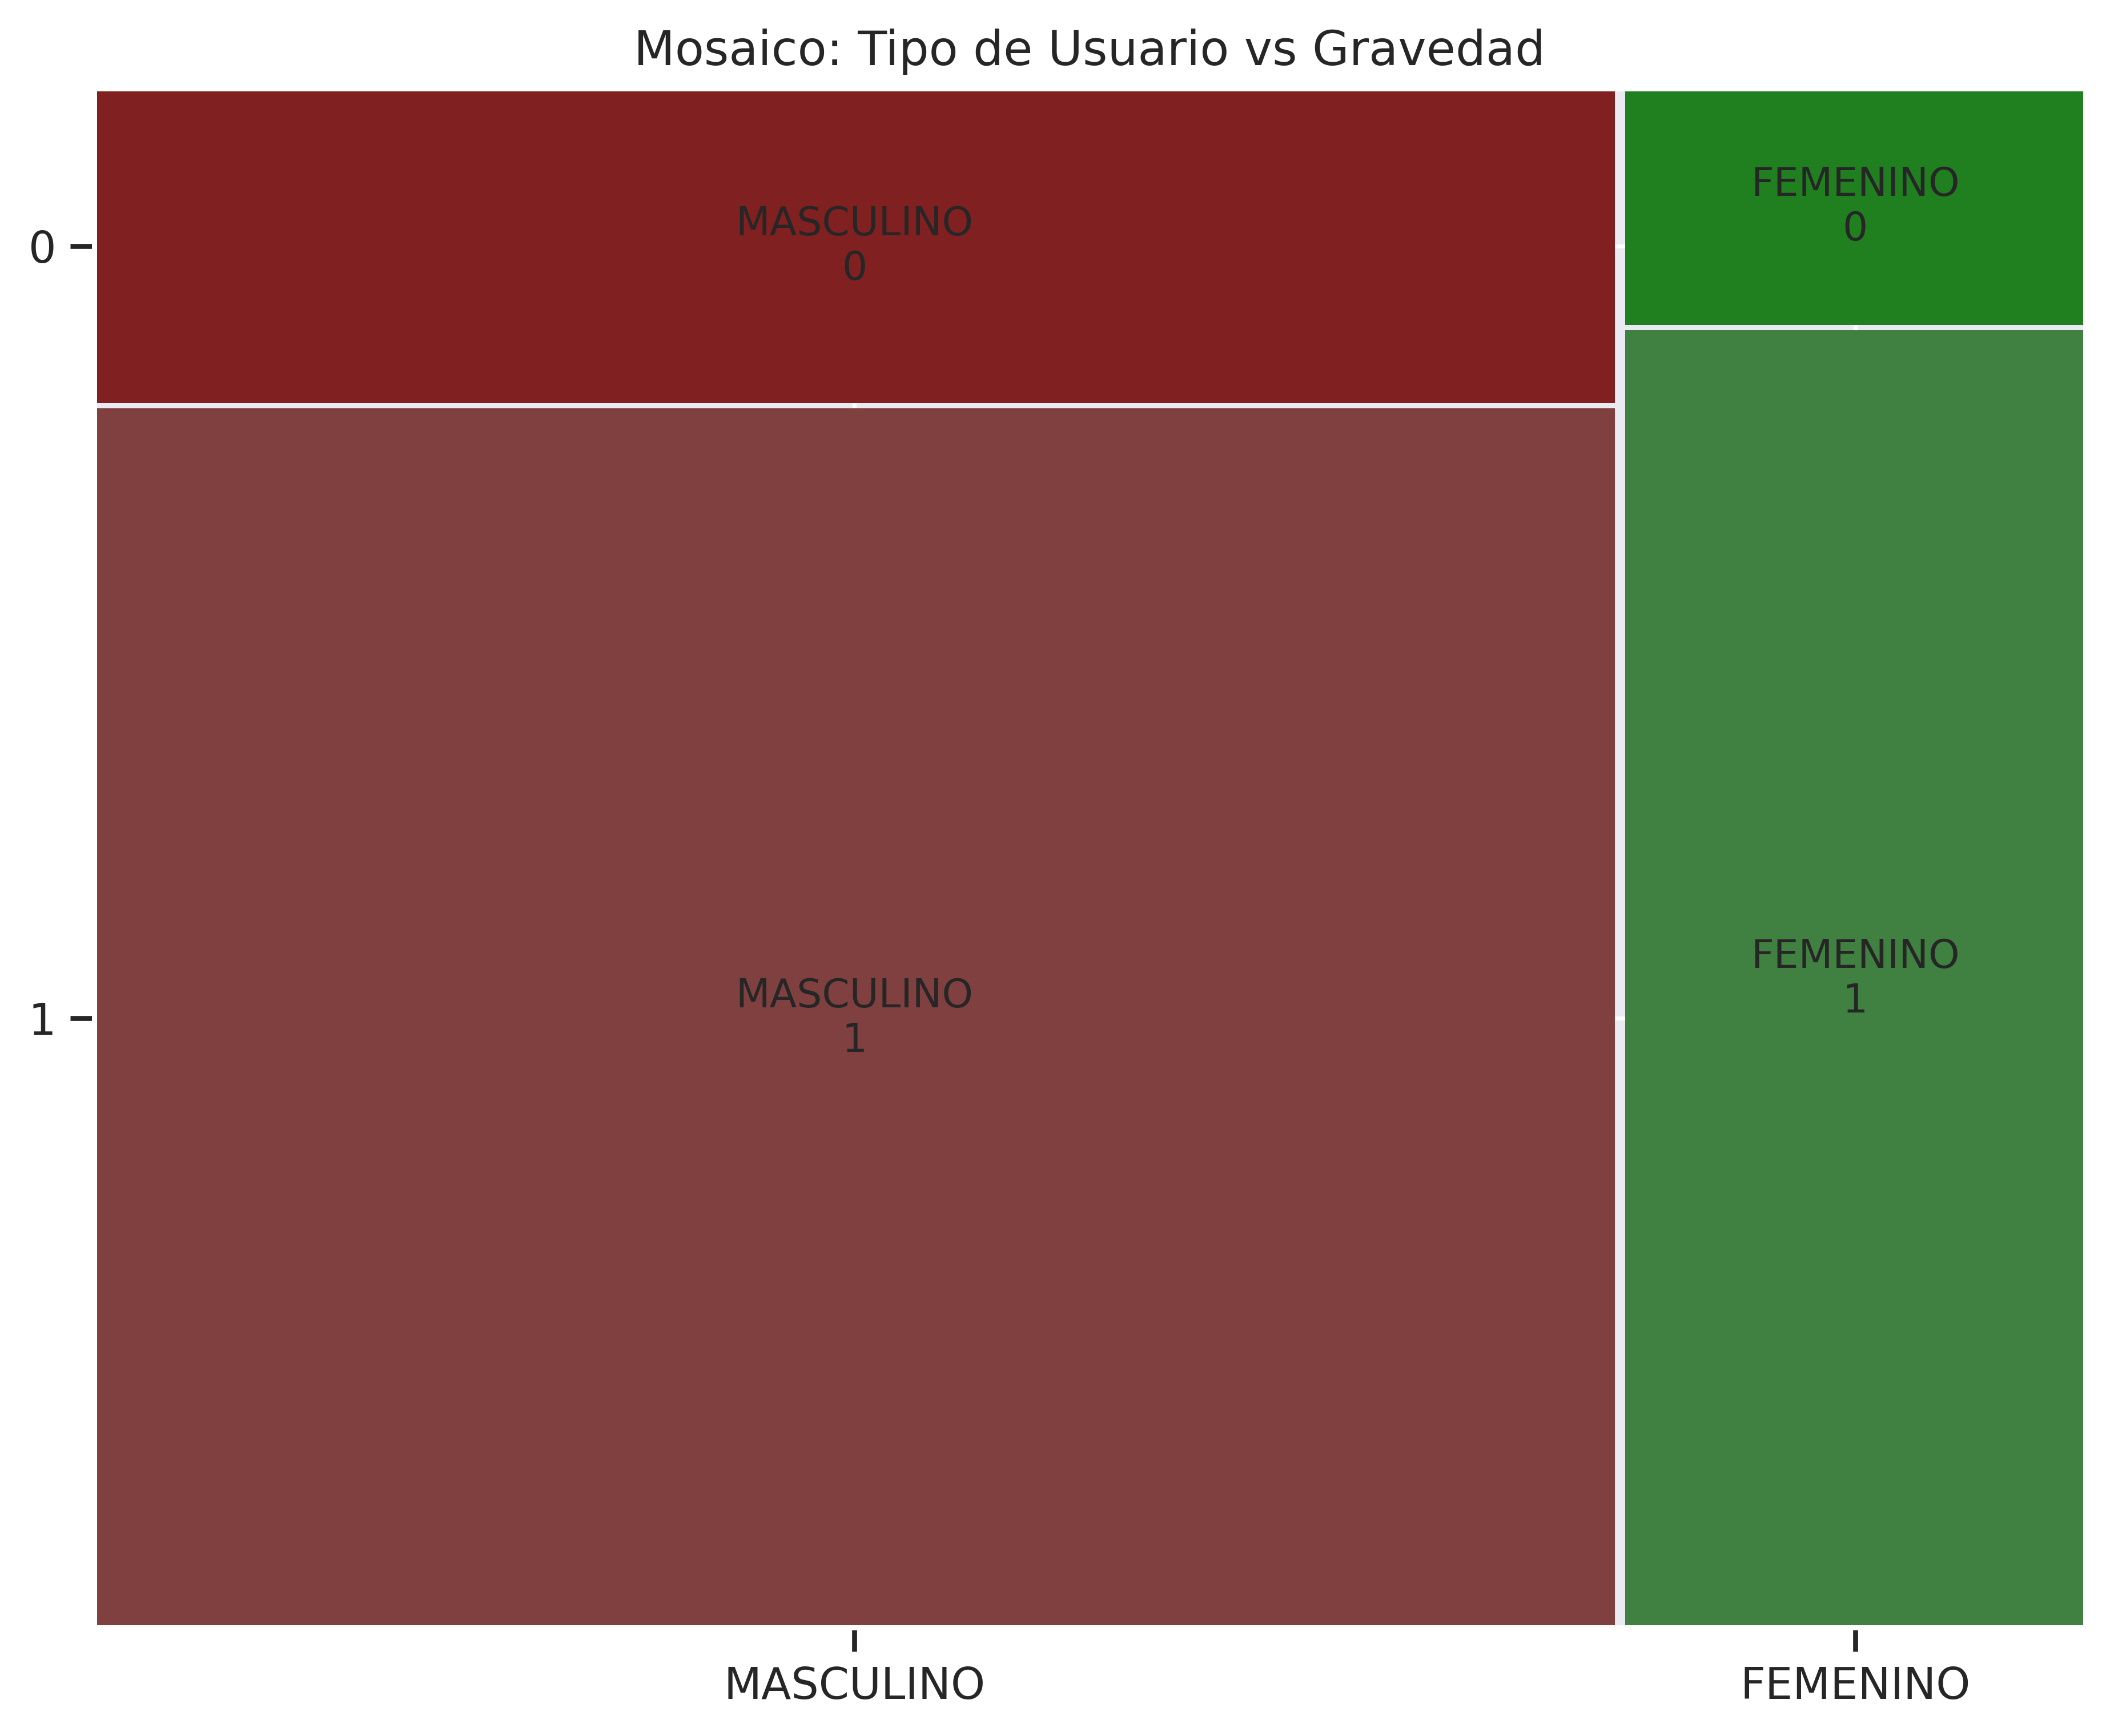

In [171]:
from statsmodels.graphics.mosaicplot import mosaic

plt.figure(figsize=(4, 4))
mosaic(ACTOR_ML, ['GENERO', 'GRAVEDAD'], title='Mosaico: Tipo de Usuario vs Gravedad')
plt.show()

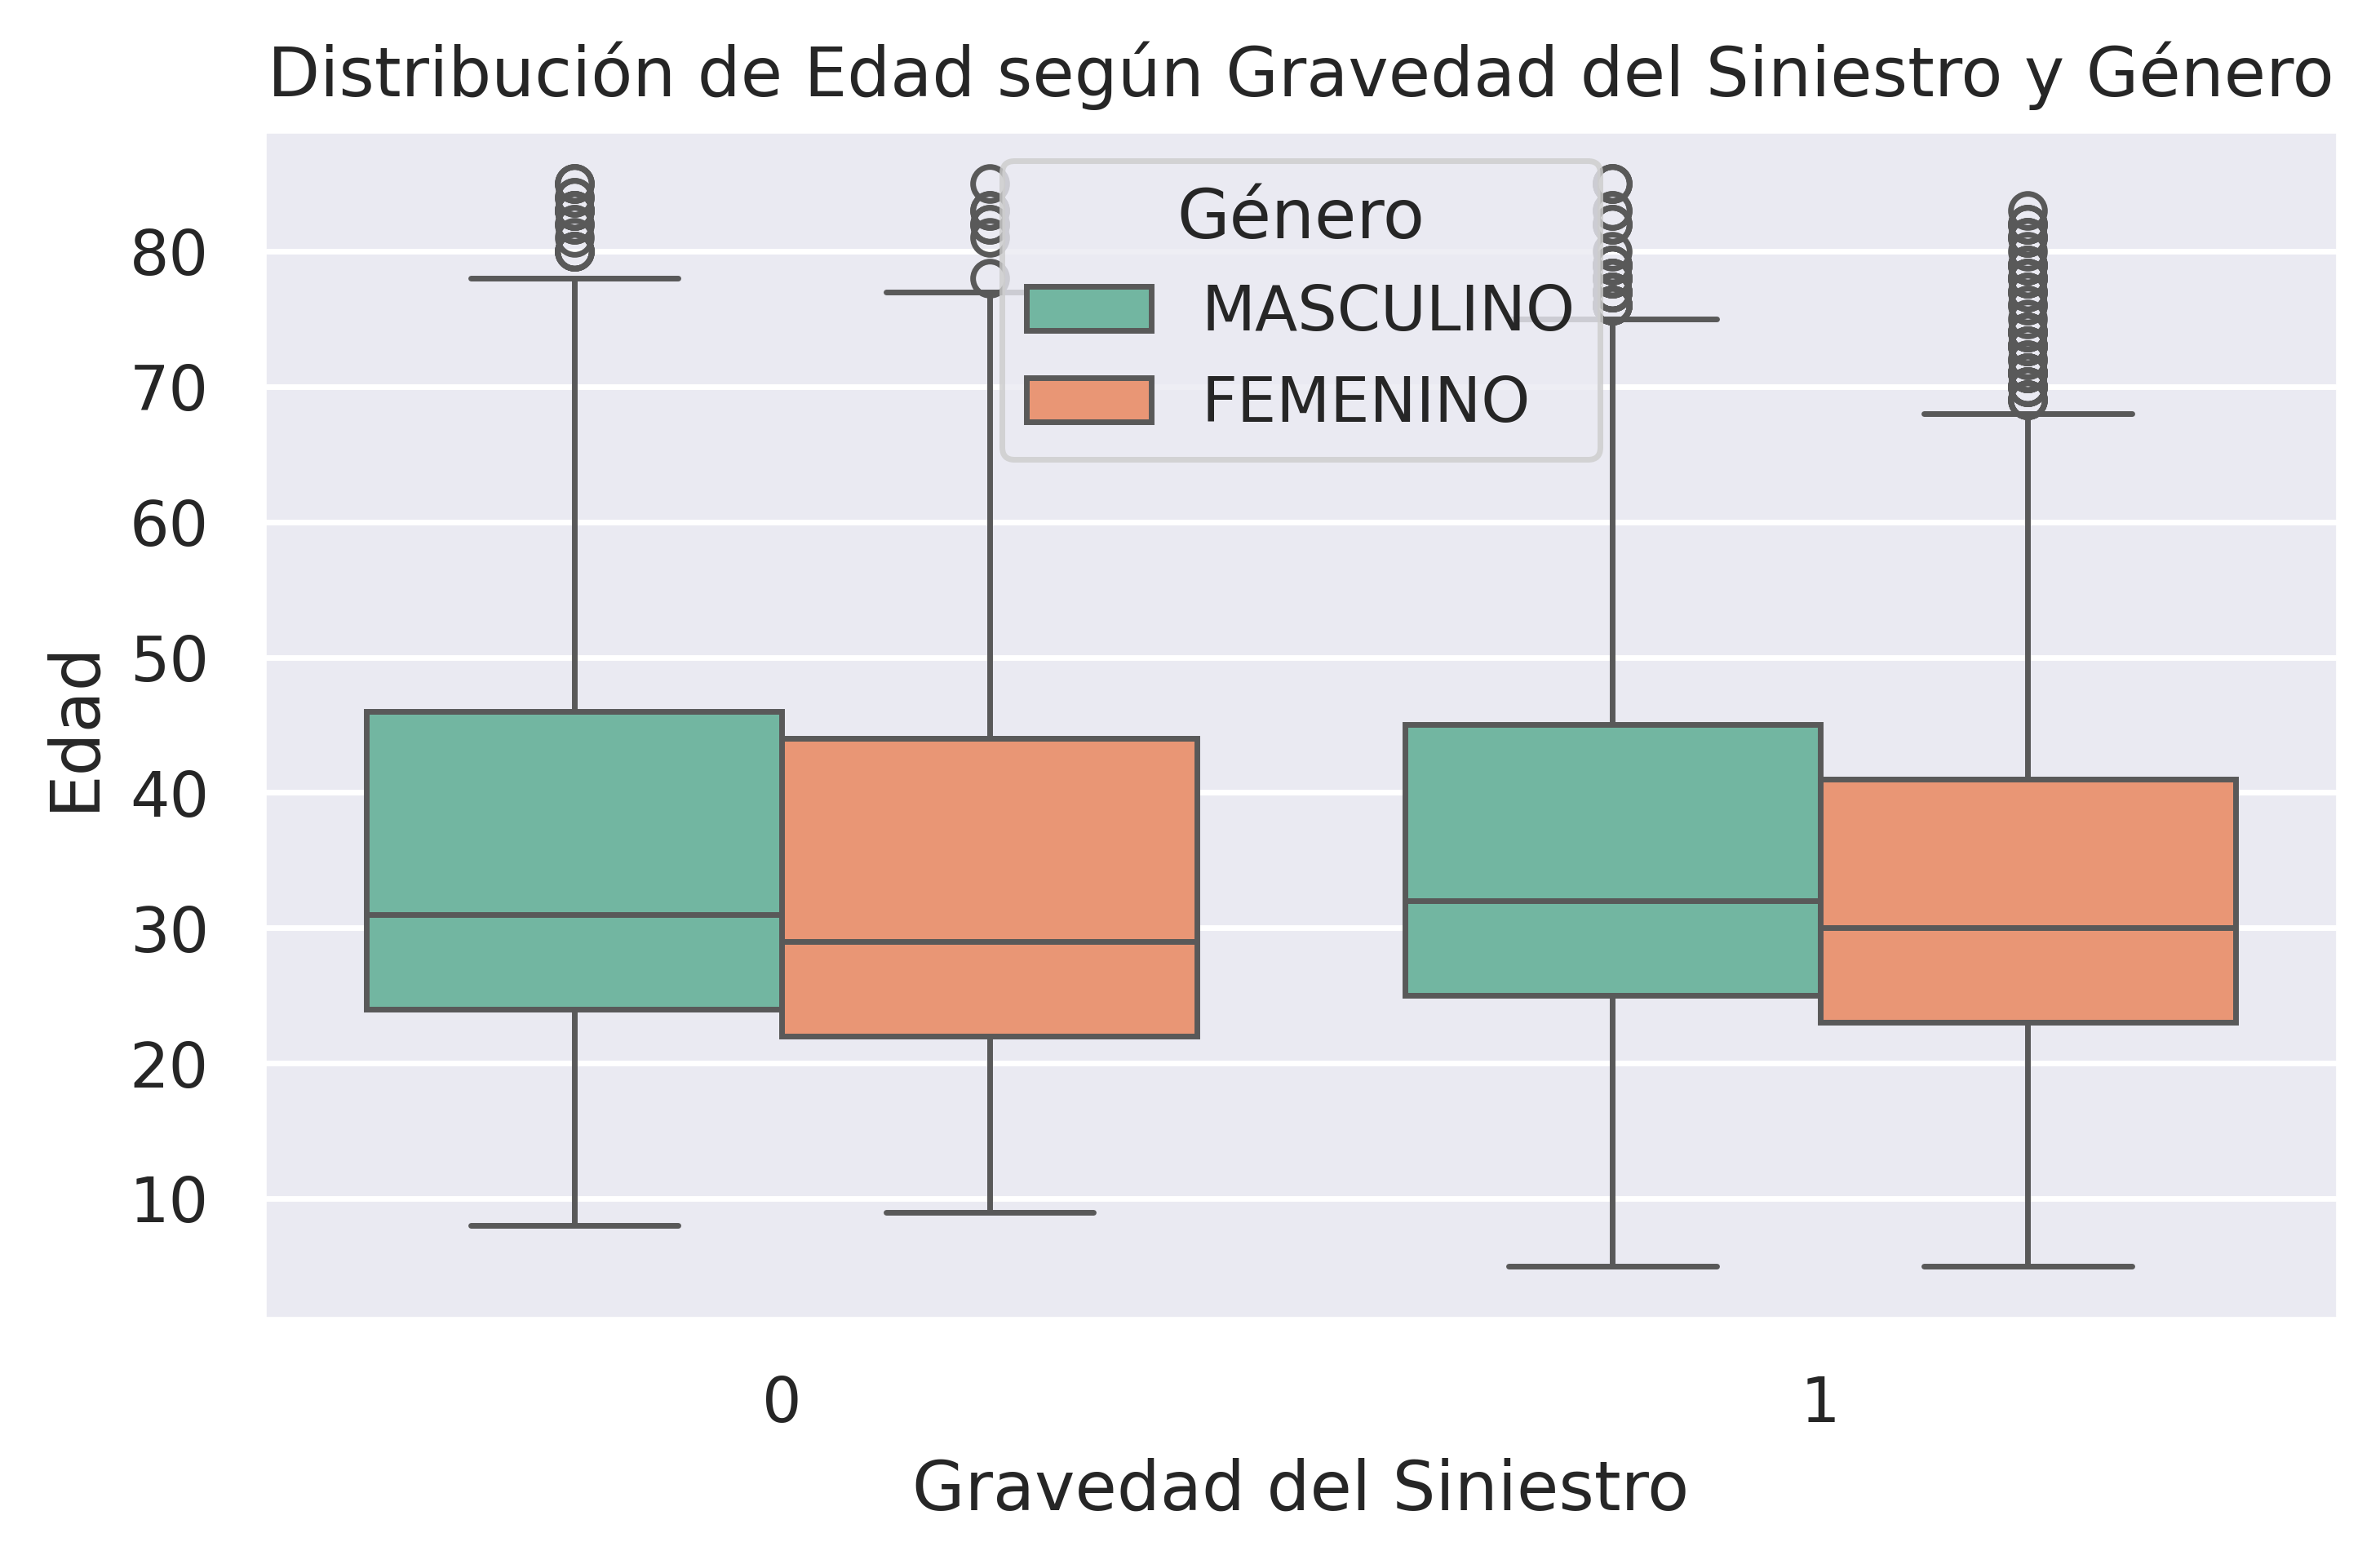

In [172]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=ACTOR_ML,
    x='GRAVEDAD',
    y='EDAD',
    hue='GENERO',
    palette='Set2'
)
plt.title('Distribución de Edad según Gravedad del Siniestro y Género')
plt.xlabel('Gravedad del Siniestro')
plt.ylabel('Edad')
plt.legend(title='Género')
plt.tight_layout()
plt.show()

### 4. PREPROCESAMIENTO INFORMACION
------------------
Para la aplicación de técnicas de Machine Learning, es importante el tratamiento adecuado de los datos que permita la posterior aplicación de las variables, así bien, en este caso al ser variables categoría, se aplicara la metodología de *“OneHotEncoder”* para el tratamiento de variables categóricas.

In [173]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [174]:
# Identificación de las variables exploratorias y respuesta para la base de datos de actores viales
X_ACTORV = ACTOR_ML.drop(['GRAVEDAD'], axis=1)
y_ACTORV  = ACTOR_ML.GRAVEDAD

print(f'El shape de X_ACTORV es: {X_ACTORV.shape}')
print(f'El shape de y_ACTORV es: {y_ACTORV.shape}')
X_ACTORV.info()

El shape de X_ACTORV es: (8209, 8)
El shape de y_ACTORV es: (8209,)
<class 'pandas.core.frame.DataFrame'>
Index: 8209 entries, 1 to 9998
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   TIPO_ACTOR         8209 non-null   object  
 1   GENERO             8209 non-null   object  
 2   CLASE_SINIESTRO    8209 non-null   object  
 3   CLASE_VEHICULO     8209 non-null   object  
 4   SERVICIO_VEHICULO  8209 non-null   object  
 5   CODIGO_CAUSA       8209 non-null   object  
 6   MODELO_CAT         8209 non-null   category
 7   EDAD               8209 non-null   Int64   
dtypes: Int64(1), category(1), object(6)
memory usage: 529.5+ KB


In [175]:
#Transformación de las variables categóricas
categoric=list(X_ACTORV.select_dtypes(['object','category']).columns)
numeric = list(X_ACTORV.select_dtypes(['int64']).columns)

tf = ColumnTransformer([('onehot', OneHotEncoder(), categoric),
                        ('scaler', StandardScaler(), numeric)])

X_ACTORV_prepr = tf.fit_transform(X_ACTORV)

print(f'El shape de X_ACTORV es: {X_ACTORV.shape}')
print(f'El shape de X_ACTORV_prepr es: {X_ACTORV_prepr.shape}')

El shape de X_ACTORV es: (8209, 8)
El shape de X_ACTORV_prepr es: (8209, 35)


In [176]:
categoric

['TIPO_ACTOR',
 'GENERO',
 'CLASE_SINIESTRO',
 'CLASE_VEHICULO',
 'SERVICIO_VEHICULO',
 'CODIGO_CAUSA',
 'MODELO_CAT']

In [177]:
numeric

['EDAD']

In [178]:
#Nombre con las diferentes Categorias
onehot_categories = tf.named_transformers_['onehot'].get_feature_names_out()
scaler_categories = tf.named_transformers_['scaler'].get_feature_names_out()
ACTOR_NAMES=np.concatenate((onehot_categories, scaler_categories), axis=0)
ACTOR_NAMES

array(['TIPO_ACTOR_ACOMPANANTE', 'TIPO_ACTOR_CICLISTA',
       'TIPO_ACTOR_CONDUCTOR', 'TIPO_ACTOR_MOTOCICLISTA',
       'TIPO_ACTOR_PASAJERO', 'TIPO_ACTOR_PEATON', 'GENERO_FEMENINO',
       'GENERO_MASCULINO', 'CLASE_SINIESTRO_ATROPELLO',
       'CLASE_SINIESTRO_CHOQUE', 'CLASE_VEHICULO_AUTOMOVIL',
       'CLASE_VEHICULO_BICICLETA', 'CLASE_VEHICULO_BUS',
       'CLASE_VEHICULO_CAMION', 'CLASE_VEHICULO_CAMIONETA',
       'CLASE_VEHICULO_CAMPERO', 'CLASE_VEHICULO_MICROBUS',
       'CLASE_VEHICULO_MOD_PEATONAL', 'CLASE_VEHICULO_MOTOCICLETA',
       'SERVICIO_VEHICULO_PARTICULAR', 'SERVICIO_VEHICULO_PUBLICO',
       'SERVICIO_VEHICULO_SER_BICICLETA',
       'SERVICIO_VEHICULO_SER_PEATONAL', 'CODIGO_CAUSA_DESOBEDECER_SENAL',
       'CODIGO_CAUSA_NO_DETALLE', 'CODIGO_CAUSA_OTRAS',
       'MODELO_CAT_(1900, 1990]', 'MODELO_CAT_(1990, 2000]',
       'MODELO_CAT_(2000, 2010]', 'MODELO_CAT_(2010, 2015]',
       'MODELO_CAT_(2015, 2020]', 'MODELO_CAT_(2020, 2025]',
       'MODELO_CAT_(2025, 3500

### 5. AGRUPACIÓN DE VARIABLES POR PCA

------

La aplicación de PCA permite reducir la dimensionalidad del conjunto de datos, identificando combinaciones lineales de variables originales que explican la mayor parte de la varianza. En el contexto del análisis de la variable de interés SIN (siniestros), el PCA facilita la identificación de aquellas variables que más contribuyen a la variabilidad general del sistema, lo que resulta clave para entender los factores subyacentes que podrían estar relacionados con la ocurrencia de siniestros y para orientar de manera más eficiente los análisis posteriores o la toma de decisiones.

In [179]:

principal=PCA(n_components=34)
principal.fit(X_ACTORV_prepr)
x=principal.transform(X_ACTORV_prepr)

# Check the dimensions of data after PCA
print(x.shape)

(8209, 34)


In [180]:
varianza_expl = principal.explained_variance_ratio_
print(varianza_expl)

[2.29356532e-01 1.31405219e-01 1.17107945e-01 9.20292381e-02
 7.74641787e-02 7.37965181e-02 4.58702034e-02 4.22765045e-02
 3.18786431e-02 2.98269151e-02 2.36092958e-02 2.19490056e-02
 1.99123833e-02 1.82803446e-02 1.04775684e-02 9.52063643e-03
 7.03172631e-03 5.69109397e-03 3.95547779e-03 3.26314262e-03
 2.99966428e-03 2.29776355e-03 6.16916109e-33 2.56611231e-33
 1.18337184e-33 1.18337184e-33 1.18337184e-33 1.18337184e-33
 1.18337184e-33 1.18337184e-33 1.18337184e-33 1.18337184e-33
 1.18337184e-33 1.69087602e-34]


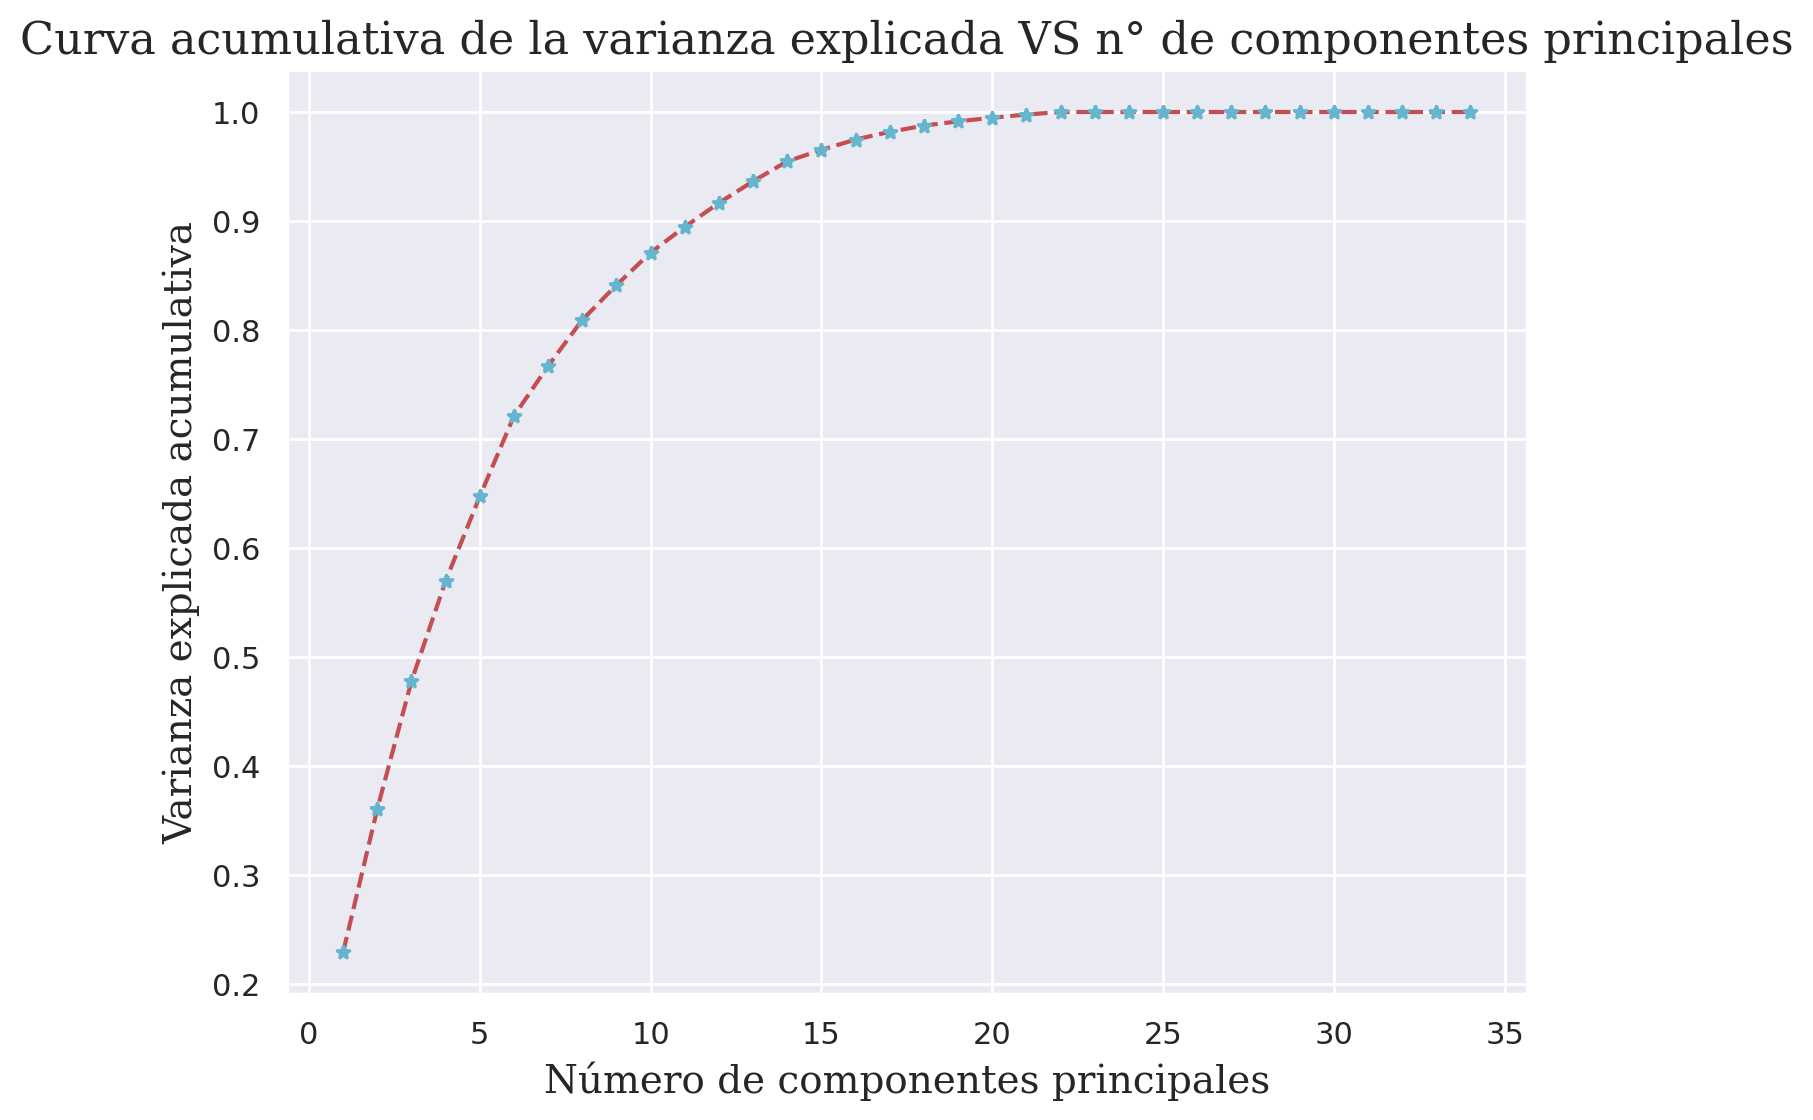

In [181]:
cumulative_explained_variance_plot(varianza_expl)

In [182]:

# Crear DataFrame con la varianza explicada
df_varianza = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(varianza_expl))],
    'Varianza Explicada (%)': varianza_expl * 100
})
# Mostrar ordenado
df_varianza = df_varianza.sort_values(by='Varianza Explicada (%)', ascending=False).reset_index(drop=True)

In [183]:
# Obtener los nombres de las variables originales si están disponibles
nombres_variables =ACTOR_NAMES

# Matriz de cargas
loadings = pd.DataFrame(principal.components_.T,
                        columns=[f'PC{i+1}' for i in range(principal.n_components_)],
                        index=nombres_variables)

# Ver las variables que más aportan a cada componente
# Ejemplo: top 5 variables para PC1
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(15)
print("Top variables que más aportan a PC1:")
print(top_pc1)

Top variables que más aportan a PC1:
EDAD                              0.836580
CLASE_VEHICULO_MOTOCICLETA        0.280989
TIPO_ACTOR_MOTOCICLISTA           0.224907
SERVICIO_VEHICULO_PARTICULAR      0.216269
TIPO_ACTOR_CONDUCTOR              0.200487
SERVICIO_VEHICULO_PUBLICO         0.133139
CLASE_VEHICULO_AUTOMOVIL          0.098374
MODELO_CAT_(2015, 2020]           0.097989
CLASE_VEHICULO_MOD_PEATONAL       0.075491
SERVICIO_VEHICULO_SER_PEATONAL    0.075491
MODELO_CAT_(2025, 3500]           0.075491
TIPO_ACTOR_PEATON                 0.075491
MODELO_CAT_(2020, 2025]           0.075143
CLASE_SINIESTRO_ATROPELLO         0.059016
CLASE_SINIESTRO_CHOQUE            0.059016
Name: PC1, dtype: float64


In [184]:
principal=PCA(n_components=15)
principal.fit(X_ACTORV_prepr)
X_ACTORV_PCA=principal.transform(X_ACTORV_prepr)

### 6. DEFINICIÓN DE BASES DE ENTRENAMIENTO Y PRUEBA
------------
Para los ejercicios de Machine Learning, es relevante la adecuada separación de los conjuntos de entrenamiento y pruebas, así bien se aplican funciones de *sklearn* para la separación de los datos.

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ACTORV_PCA,
                                                    y_ACTORV,
                                                    test_size=0.3,
                                                    stratify=y_ACTORV,
                                                    random_state=42)

In [186]:
print(f'Número de muestras en entrenamiento: {X_train.shape[0]}')
print(f'Número de muestras en prueba: {X_test.shape[0]}')
print(f'Número de características: {X_train.shape[1]}')
print(f'Distribución de clases en entrenamiento: {np.bincount(y_train)}')
print(f'Distribución de clases en prueba: {np.bincount(y_test)}')

Número de muestras en entrenamiento: 5746
Número de muestras en prueba: 2463
Número de características: 15
Distribución de clases en entrenamiento: [1111 4635]
Distribución de clases en prueba: [ 476 1987]


In [187]:
gravedad_names=['MUERTO', 'HERIDO']


## IV APLICACION DE ALGORITMOS DE ML
--------------
En el siguiente apartado se aplicarán diferentes algoritmos de aprendizaje para clasificación de parametros.

En este apartado, primero se aplican algoritmos por validación cruzada para la identificación de los modelos de mayor desempeño y posteriormente se prueba el desempeño del mejor modelo.

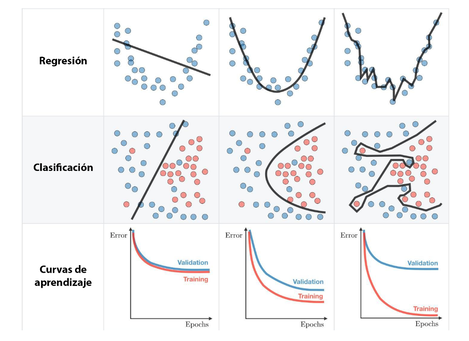

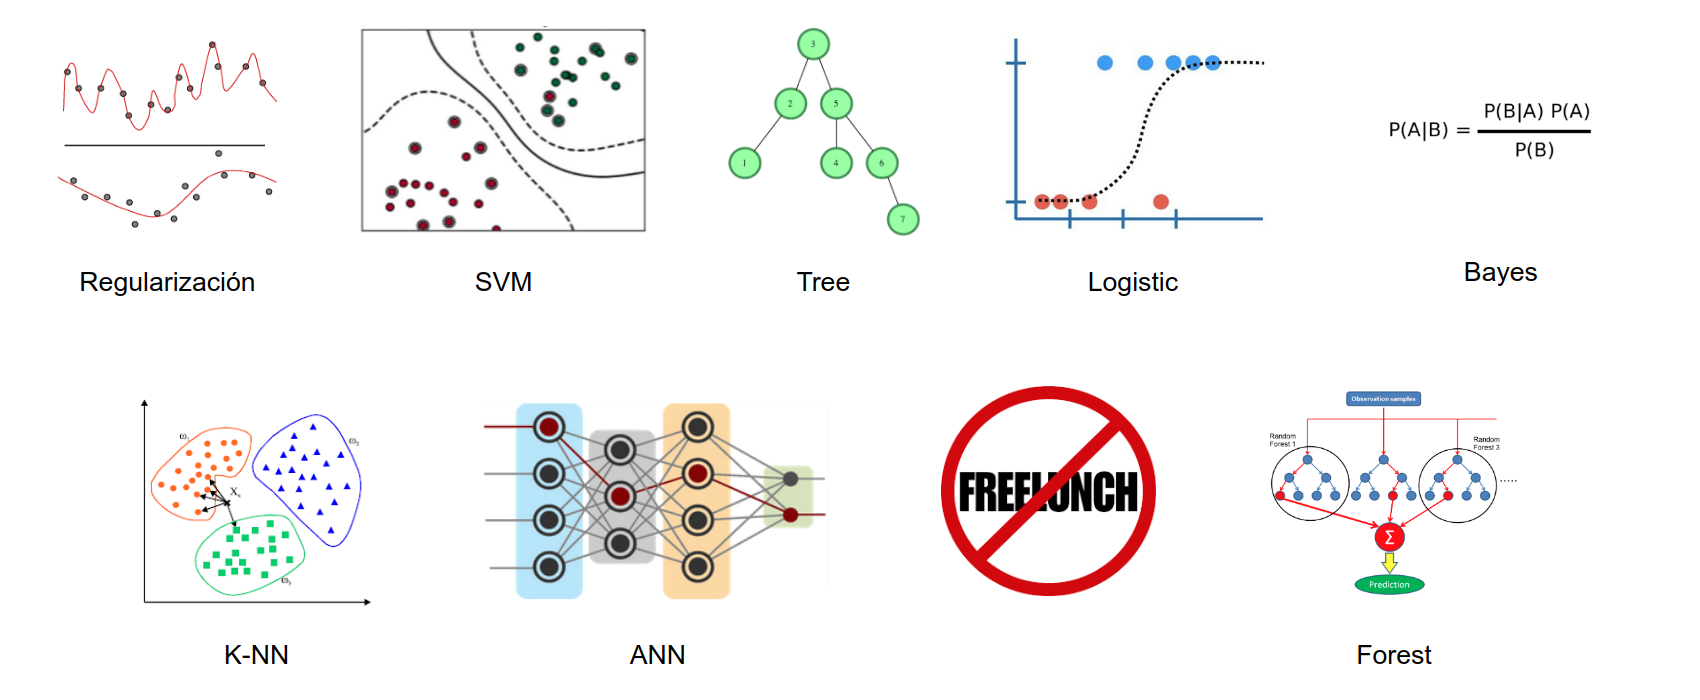

#### A) Algoritmo: K-vecinos más cercanos (KNN)



In [188]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

##### KNN GridSearchCV

In [189]:
#parámetros básicos para la aplicación del CV-grid
knn = KNeighborsClassifier()
k_range = list(range(2, 5))
param_grid = dict(n_neighbors=k_range)

In [190]:
# Aplicación de CV-Grid para identificación de Hyperparametros
grid_knn = GridSearchCV(knn,
                   param_grid=param_grid,
                   verbose=3,
                   cv=5,
                   n_jobs=-1,
                   scoring='accuracy',
                   return_train_score=True
                   )
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4]}, return_train_score=True,
             scoring='accuracy', verbose=3)

In [191]:
#Cálculo de los resultados del Grid
pd.DataFrame(grid_knn.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,0.013940,0.000222,0.042999,0.005027,3,{'n_neighbors': 3},0.773043,0.773716,0.775457,0.773716,...,0.772537,0.003000,1,0.866841,0.857733,0.858603,0.858821,0.855558,0.859511,0.003842
2,0.015099,0.001284,0.047887,0.002104,4,{'n_neighbors': 4},0.746087,0.738033,0.747607,0.733681,...,0.741907,0.005245,2,0.836815,0.832499,0.831629,0.835762,0.836633,0.834668,0.002173
0,0.016700,0.003134,0.035415,0.003797,2,{'n_neighbors': 2},0.673913,0.664926,0.696258,0.665796,...,0.675601,0.011331,3,0.829417,0.838373,0.839896,0.828584,0.825973,0.832449,0.005597


In [192]:
resut_KNN= pd.DataFrame(grid_knn.cv_results_).sort_values(by='rank_test_score', ascending=True)
resut_KNN.to_csv('C:\\sqldeveloper\\sqldeveloper\\bin\\resut_KNN_cv5.csv', index=False,header=True)

In [193]:
# Mejores parámetros identificados.
print(grid_knn.best_params_)
n_neighbors=list(grid_knn.best_params_.values())[0]

{'n_neighbors': 3}


In [194]:
# Puntaje de la mejor combinación de parámetros.
print(grid_knn.best_score_)

0.7725373292466038


##### KNN Best Model

In [195]:
#Caculo del modelo optimizado previamente identificado, con los mejores hiperparametros
KNN_cl = KNeighborsClassifier(n_neighbors=n_neighbors)

In [196]:
KNN_fit=KNN_cl.fit(X_train, y_train)

In [197]:
print(f'Error entrenamiento: {1 - KNN_fit.score(X_train, y_train)}')
print(f'Error generalización: {1 - KNN_fit.score(X_test, y_test)}')

Error entrenamiento: 0.13974939088061256
Error generalización: 0.23223710921640273


In [198]:
#Estimación de la predicción para el mejor modelo
KNN_pred = KNN_fit.predict(X_test)

In [199]:
# Generación de la matriz de confusión.
KNN_mat = confusion_matrix(y_test, KNN_pred)
list_confusion_matrix(KNN_mat, ['MUERTO', 'HERIDO'])

Valor predicho       
                          MUERTO HERIDO
Valor real MUERTO            100    376
           HERIDO            196   1791

In [200]:
#Estimación de los estadísticos de desempeño del modelo.
print(f'Orden de las etiquetas: {gravedad_names}')
print(f'Precisión por clase: \t{precision_score(y_test, KNN_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, KNN_pred, average=None)}')
print(f'F1 por clase: \t{f1_score(y_test, KNN_pred, average=None)}')

Orden de las etiquetas: ['MUERTO', 'HERIDO']
Precisión por clase: 	[0.33783784 0.82648823]
Recall por clase: 	[0.21008403 0.90135883]
F1 por clase: 	[0.25906736 0.8623014 ]


In [201]:
#Estimación de los estadísticos contemplado los errores en el modelo
print(f"Precisión micro: {precision_score(y_test, KNN_pred, average='micro'):.4f}")
print(f"Recall micro: {recall_score(y_test, KNN_pred, average='micro'):.4f}")
print(f"F1 micro: {f1_score(y_test, KNN_pred, average='micro'):.4f}")

Precisión micro: 0.7678
Recall micro: 0.7678
F1 micro: 0.7678


#### B)  Algoritmo: RAMDOM FORREST

#### C)  Algoritmo: MAQUINA DE SOPORTE VECTORIAL


#### D)  Algoritmo: REGRESION LOGISTICA

#### E)  Algoritmo: REGRESION RED NEURONAL

## v.	CONCLUSIONES
-----------------
Los resultados de la aplicación de algoritmos de clasificación de aprendizaje de máquina presentaron una buena estimación para identificar los niveles de severidad en los siniestros viales registrados en la ciudad de Bogotá, Colombia. La exactitud promedio para el control de pruebas con los diferentes algoritmos estuvo por encima del 80%, siendo aceptable para todos los modelos aplicados. La investigación mostró que la aplicación de algoritmos más complejos de estimar como lo son SVM y MLP presentó levemente un mejor desempeño sin que este resultara ser mayormente significativo respecto a metodologías como LOGREG, RF, KNN, siendo cualquiera una herramienta deseable para la estimación de la severidad de los accidentes en la ciudad de Bogotá. De manera que, entidades encargadas de la gestión de la seguridad vial y profesionales pueden aplicar metodologías basadas en clasificadores para establecer medidas preventivas y correctivas en el estudio de la siniestralidad, de manera que, la implementación de enfoques basados en aprendizaje de máquina resulta ser pertinente en función de los resultados.

Al analizar los resultados de la predicción para cada uno de los niveles de severidad, se evidencia que los clasificadores resultan ser particularmente eficiente en la estimación de eventos con heridos y solo daños teniendo un alto rendimiento en las diferentes métricas de desempeño, mientras que para el caso de los siniestros con fatalidades, las técnicas empleadas no presentaban un buen rendimiento, siendo KNN la única capaz de representar de manera parcial los eventos con fatalidad, esto se puede dar debido a la diferencia tan alta en la cantidad de eventos con esta severidad, así como a la necesidad de incorporar otras variables que pudieran estar relacionadas con el siniestro como lo son las condiciones climáticas, las características de la vía, entre otras.

Así bien, la investigación muestra la pertinencia en la implementación de enfoques basados en aprendizaje de máquina en el estudio de la severidad en la siniestralidad en ciudades como Bogotá, donde la aplicación de algoritmos de clasificación tienen un desempeño deseable en la estimación de la severidad para la estimación de heridos y daños, mientras para el caso de las fatalidades es menos técnicas como KNN presentan resultados alentadores en la estimación de siniestros mortales que pueden ser implementados en el estudio sistemático de la siniestralidad.

